# Install and import libraries

In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm, trange
import csv
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import statistics

import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertTokenizer, BertConfig

from keras_preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

import transformers
from transformers import BertForTokenClassification, AdamW
from transformers import get_linear_schedule_with_warmup

from seqeval.metrics import f1_score, accuracy_score

2023-07-18 11:12:56.518670: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-18 11:12:57.039384: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# Check GPU availability

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()
torch.cuda.get_device_name(0)

'NVIDIA GeForce RTX 2080 Ti'

# **Preprocessing data**

In [3]:
# Reading data
import json


#open the file, and format correctly
f =open('dataset.jsonl', 'r')
json_object = json.dumps(f.readlines(), indent=4)
f.close()

#save better format into file
p = open('sample.txt', 'w')
for i in json_object:
    p.write(i)
p.close()

#open new file, and save each 
j = open('sample.txt', 'r')
text = json.loads(j.read())
j.close()

#compile all json dicts into a list
info = []
for i in text:
    info.append(json.loads(str(i)))
    

In [4]:
def labeler1(sent, text, annotations):
    def fun(x):
        return x['start_offset']
    annotations.sort(key=fun)
    #sent will be the already parsed sentence, with everything removed
    #text will be the straight sentence, info[i]['text']
    #annotations will be the list of labels, must be info[i]['annotations']
    
    #monitor where in the text we are
    text_index = 0
    
    #monitor which word we are in
    sent_index = 0
    
    #keep track of which annotation label we are applying
    annotation_index = 0
    
    #will return all labels for each words
    labels = []
  
    while text_index < len(text) and sent_index < len(sent):
        if annotation_index >= len(annotations):
            for i in range(len(labels)-1, len(sent)):
                labels.append(data_tags[0])
                return labels
        
        #check if we are at the correct index
        if text[text_index]== sent[sent_index][0]:
            
            #double check
            if len(sent[sent_index])==1 or text[text_index+1]== sent[sent_index][1]:
                
                #if not true and the current label aplies to text behind the index behind current, adjest label that you are looking at
                if text_index > annotations[annotation_index]['end_offset']:
                    annotation_index +=1
                    
                else:
            
                    #check if the current text label falls in a label range.
                    #if true, apply correct label and move text_index and sent_index
                    if text_index >= annotations[annotation_index]['start_offset'] and text_index <= annotations[annotation_index]['end_offset']:
                        if len(labels)==0:
                            labels.append(data_tags[2*(annotations[annotation_index]['label'])])
                        elif labels[-1] == data_tags[2*(annotations[annotation_index]['label'])] or labels[-1] == data_tags[2*(annotations[annotation_index]['label'])-1]:
                            labels.append(data_tags[2*(annotations[annotation_index]['label'])])
                        else:
                            labels.append(data_tags[2*(annotations[annotation_index]['label'])-1])
                    
                    #if no label applies, apply '0' tag
                    else:
                        labels.append(data_tags[0])
                    
                    #adjust which word you are looking at and text_index
                    text_index += len(sent[sent_index])
                    sent_index += 1
                    
                
            else:
                text_index+=1
        else:
            text_index+=1
            
            
    return labels
        
 

In [5]:
def labeler1(sent, text, annotations):
    def fun(x):
        return x['start_offset']
    annotations.sort(key=fun)
    #sent will be the already parsed sentence, with everything removed
    #text will be the straight sentence, info[i]['text']
    #annotations will be the list of labels, must be info[i]['annotations']
    
    #monitor where in the text we are
    text_index = 0
    
    #monitor which word we are in
    sent_index = 0
    
    #keep track of which annotation label we are applying
    annotation_index = 0
    
    #will return all labels for each words
    labels = []
  
    while text_index < len(text) and sent_index < len(sent):
        if annotation_index >= len(annotations):
            for i in range(len(labels)-1, len(sent)):
                labels.append(data_tags[0])
                return labels
        
        #check if we are at the correct index
        if text[text_index]== sent[sent_index][0]:
            
            #double check
            if len(sent[sent_index])==1 or text[text_index+1]== sent[sent_index][1]:
                
                #if not true and the current label aplies to text behind the index behind current, adjest label that you are looking at
                if text_index > annotations[annotation_index]['end_offset']:
                    annotation_index +=1
                    
                else:
            
                    #check if the current text label falls in a label range.
                    #if true, apply correct label and move text_index and sent_index
                    if text_index >= annotations[annotation_index]['start_offset'] and text_index <= annotations[annotation_index]['end_offset']:
                        if len(labels)==0:
                            labels.append(data_tags[2*(annotations[annotation_index]['label'])-1])
                        elif labels[-1] == data_tags[2*(annotations[annotation_index]['label'])] or labels[-1] == data_tags[2*(annotations[annotation_index]['label'])-1]:
                            labels.append(data_tags[2*(annotations[annotation_index]['label'])])
                        else:
                            labels.append(data_tags[2*(annotations[annotation_index]['label'])-1])
                    
                    #if no label applies, apply '0' tag
                    else:
                        labels.append(data_tags[0])
                    
                    #adjust which word you are looking at and text_index
                    text_index += len(sent[sent_index])
                    sent_index += 1
                    
                
            else:
                text_index+=1
        else:
            text_index+=1
            
            
    return labels
        
 

In [6]:
def labeler2(sent, text, annotations):
    def fun(x):
        return x['start_offset']
    annotations.sort(key=fun)
    #sent will be the already parsed sentence, with everything removed
    #text will be the straight sentence, info[i]['text']
    #annotations will be the list of labels, must be info[i]['annotations']
    
    #monitor where in the text we are
    text_index = 0
    
    #keep track of which annotation label we are applying
    annotation_index = 0
    
    #will return all labels for each words
    labels = []
    
    for i in range(0, len(sent)):
        if len(annotations) ==0:
            return [data_tags[0] for j in range(len(sent[i]))]
                    
        elif text_index == annotations[annotation_index]['start_offset']:
            
            labels.append(data_tags[2 * annotations[annotation_index]['label']-1])
            
        elif text_index >= annotations[annotation_index]['start_offset'] and text_index <= annotations[annotation_index]['end_offset']:
            if labels[i-1]==data_tags[0]:
                
                labels.append(data_tags[2 * annotations[annotation_index]['label']-1])
            else:
               
                labels.append(data_tags[(2 * annotations[annotation_index]['label'] ) ])
            
        elif text_index > annotations[annotation_index]['end_offset']:
            if text_index + 1 == annotations[annotation_index]['start_offset']:
                
                labels.append(data_tags[2 * annotations[annotation_index]['label']-1])
            else: 
                annotation_index+=1
               
                labels.append(data_tags[0])
                if annotation_index>=len(annotations):
                    annotation_index = annotation_index -1
        else:
        
            labels.append(data_tags[0])
            
        text_index+= (len(sent[i])+1)
    return labels
    

In [7]:
def all_in_one (text, annotations):
    #text will be the straight sentence, info[i]['text']
    #annotations will be the list of labels, must be info[i]['annotations']
    
    partitions = []
    section_labels = []
    labels = []
    sentences = []
    
    def fun(x):
        return x['start_offset']
    annotations.sort(key=fun)
    
    a_len =  len(annotations)
    t_len = len(text)
    
    if a_len == 0:
        sentences = text.split()
        for s in sentences:
            labels.append(data_tags[0])
        return sentences, labels
    
    if annotations[0]['start_offset'] == 0:
        partitions.append(text[: annotations[0]['end_offset']])
        section_labels.append(annotations[0]['label'])
    else:
        partitions.append(text[: annotations[0]['start_offset']])
        section_labels.append(0)
        partitions.append(text[annotations[0]['start_offset']: annotations[0]['end_offset']])
        section_labels.append(annotations[0]['label'])
        
        
    for i in range(1, a_len -1):
        if annotations[i]['start_offset'] == annotations[i-1]['end_offset']:
            partitions.append(text[annotations[i]['start_offset']: annotations[i]['end_offset']])
            section_labels.append(annotations[i]['label'])
        else:
            partitions.append(text[annotations[i-1]['end_offset']: annotations[i]['start_offset']])
            section_labels.append(0)
            partitions.append(text[annotations[i]['start_offset']: annotations[i]['end_offset']])
            section_labels.append(annotations[i]['label'])
            
    
    if annotations[a_len-1]['start_offset'] == t_len:
        partitions.append(text[annotations[a_len-1]['start_offset']:])
        section_labels.append(annotations[a_len-1]['label'])
    else:
        partitions.append(text[annotations[a_len-1]['start_offset']: annotations[a_len-1]['end_offset']])
        section_labels.append(annotations[a_len-1]['label'])
        partitions.append(text[annotations[a_len-1]['end_offset']: ])
        section_labels.append(0)
        
        
    for i in range(len(section_labels)):
        p_split = partitions[i].split()
        p_len = len(p_split)
        if p_len > 0:
            sentences.extend(p_split)
            if section_labels[i] == 0:
                for p in p_split:
                    labels.append(data_tags[0])
            else:
                labels.append(data_tags[2 * section_labels[i] -1])
                for j in range(1, p_len):
                     labels.append(data_tags[2 * section_labels[i]])
      
    return sentences, labels
    

In [8]:
import re

def splitter1():
    return [re.findall(r"[\w']+", info[i]['text']) for i in range(len(info))]

def splitter2():
    return [info[i]['text'].strip().split() for i in range(len(info))]
   

In [9]:
def processor(splitmethod, labelmethod):
    s = splitmethod()
    
    l=[]

    for i in range(len(s)):
        l.append(labelmethod(s[i], info[i]['text'].strip(), info[i]['annotations'] ))
    
    return s, l

In [10]:
def degreekify(char):
    #char will be a character
    greek = {'α': '[alpha]', 'β':'[beta]', 'γ': '[gamma]', 'δ':'[delta]', 'ε': '[epsilon]', 'ζ':'[zeta]', 'η': '[eta]',
            'θ':'[theta]', 'ι': '[iota]', 'κ':'[kappa]', 'λ':'[lambda]', 'μ': '[mu]', 'ν':'[nu]', 'ξ':'[xi]', 'ο':'[omicron]', 'π':'[pi]', 'ρ':'[rho]',
            'σ': '[sigma]', 'τ': '[tau]', 'υ':'[upsilon]', 'φ':'[phi]', 'χ':'[chi]', 'ψ':'[psi]', 'ω':'[omega]' }
    if char in greek:
        return greek[char]
    else:
        return char

In [11]:
def pre_process(text, annotations):
    #text will be the straight sentence, info[i]['text']
    #annotations will be the list of labels, must be info[i]['annotations']
    
    text_dict = []
    
    for i in range(len(text)):
        text_dict.append(degreekify(text[i]))
    
    
    
    ann_indices = []
    def fun(x):
        return x['start_offset']
    annotations.sort(key=fun)
    
    
    
    if len(annotations)==0:
        ann_indices.append([[0, len(text)],0])
    else:
        ann_indices.append([[0, annotations[0]['start_offset']], 0])
        for i in range(len(annotations)-1):
            ann_indices.append([[annotations[i]['start_offset'], annotations[i]['end_offset']], annotations[i]['label']])
            ann_indices.append([[annotations[i]['end_offset'], annotations[i+1]['start_offset']], 0])
            
        ann_indices.append([[annotations[-1]['start_offset'], annotations[-1]['end_offset']], annotations[-1]['label']])
        ann_indices.append([[annotations[-1]['end_offset'], len(text)], 0])
         
    
    labels = []
    sentences = []
    for a in ann_indices:
        
        if a[0][1]-a[0][0] !=0:
            together = ''
            for i in range(a[0][0], a[0][1]):
                together += text_dict[i]
                
            toke = together.split()
            sentences.extend(toke)
            t = len(toke)
            temp = [data_tags[2 * a[1]]] * t
            if a[1] != 0:
                temp[0] = data_tags[2 * a[1]-1]
            labels.extend(temp)
 
    return labels, sentences

In [12]:
#create labels
data_tags = ['0','C', 'C-cont' , 'M', 'M-cont', 'Q', 'Q-cont', 'T' , 'T-cont', 'A' , 'A-cont', 'R', 'R-cont']




sentences, labels = [], []
for i in range(len(info)):
    l, s = pre_process(info[i]['text'], info[i]['annotations'])
    if len(l) != len(s):
        print(s, "\n", l)
    else:
        labels.append(l)
        sentences.append(s)

# q = 115
# for i in range(len(labels[q])):
#     print(sentences[q][i], labels[q][i])


In [13]:
print(labels[4])
print(sentences[4])
for i in range(len(labels[4])):
    print(sentences[4][i],labels[4][i])

['0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0']
['Upon', 'irradiation', 'of', 'such', 'a', 'complex', 'heterogeneous', 'system,', 'in', 'addition', 'to', 'the', 'direct', 'radiation', 'effect', 'on', 'the', 'sorbent,', 'an', 'indirect', 'effect', 'is', 'also', 'observed,', 'which', 'consists', 'in', 'the', 'fact', 'that', 'the', 'interaction', 'of', 'the', 'products', 'of', 'radiolysis', 'of', 'an', 'aqueous', 'solution', 'with', 'the', 'sorbent,', 'as', 'a', 'rule,', 'enhances', 'radiation-chemical', 'damage', 'and', 'leads', 'to', 'a', 'significant', 'decrease', 'in', 'the', 'radiation', 'resistance', 'of', 'the', 'sorbent', 'compared', 'to', 'irradiation', 'in', 'the', 'dry', 'sta

In [14]:

# Determine the list of tags
tag_values = data_tags
print(tag_values)

tag_values.append("PAD")
print(tag_values)

tag2idx = {t: i for i, t in enumerate(tag_values)}
print(tag2idx)
     

['0', 'C', 'C-cont', 'M', 'M-cont', 'Q', 'Q-cont', 'T', 'T-cont', 'A', 'A-cont', 'R', 'R-cont']
['0', 'C', 'C-cont', 'M', 'M-cont', 'Q', 'Q-cont', 'T', 'T-cont', 'A', 'A-cont', 'R', 'R-cont', 'PAD']
{'0': 0, 'C': 1, 'C-cont': 2, 'M': 3, 'M-cont': 4, 'Q': 5, 'Q-cont': 6, 'T': 7, 'T-cont': 8, 'A': 9, 'A-cont': 10, 'R': 11, 'R-cont': 12, 'PAD': 13}


In [15]:
# To use the BERT, you must use the BERT Tokenizer
tokenizer = BertTokenizer.from_pretrained('allenai/scibert_scivocab_cased', do_lower_case=True)


In [16]:
def tokenize_and_preserve_labels(sentence, text_labels):
    tokenized_sentence = []
    labels = []

    for word, label in zip(sentence, text_labels):

        # Tokenize the word and count # of subwords the word is broken into
        tokenized_word = tokenizer.tokenize(word)
        n_subwords = len(tokenized_word)

        # Add the tokenized word to the final tokenized word list
        tokenized_sentence.extend(tokenized_word)

        # Add the same label to the new list of labels `n_subwords` times
        labels.extend([label] * n_subwords)

    return tokenized_sentence, labels


In [17]:
for s, l in zip(sentences, labels):
    s, l = tokenize_and_preserve_labels(s, l)
    if len(s) != len(l):
        print('fuck')

In [18]:
tokenized_texts_and_labels = [ tokenize_and_preserve_labels(sent, labs) for sent, labs in zip(sentences, labels)]

tokenized_texts = [token_label_pair[0] for token_label_pair in tokenized_texts_and_labels]
labels = [token_label_pair[1] for token_label_pair in tokenized_texts_and_labels]

In [19]:
# MAX_LEN is the maximum length of a sequence
MAX_LEN = 128 # 64 or 128 or ...
bs = 6 # batch size


In [20]:
# Use Padding to equalize the length of sentences
input_ids = pad_sequences([tokenizer.convert_tokens_to_ids(txt) for txt in tokenized_texts],
                          maxlen=MAX_LEN, dtype="long", value=0.0,
                          truncating="post", padding="post")

tags = pad_sequences([[tag2idx.get(l) for l in lab] for lab in labels],
                     maxlen=MAX_LEN, value=tag2idx["PAD"], padding="post",
                     dtype="long", truncating="post")
     

In [21]:
# Do not mask values that are zero
attention_masks = [[float(i != 0.0) for i in ii] for ii in input_ids]

In [22]:
# Split data to train and validation. %90 for train and %10 for validation
tr_inputs, val_inputs, tr_tags, val_tags = train_test_split(input_ids, tags,
                                                            random_state=2018, test_size=0.1)

# Each mask contains 10% of a sentence
tr_masks, val_masks, _, _ = train_test_split(attention_masks, input_ids,
                                             random_state=2018, test_size=0.1)

# The input of the BERT should be the tensors produced using PyTorch
# So convert all inputs and labels into torch tensors
tr_inputs = torch.tensor(tr_inputs)
val_inputs = torch.tensor(val_inputs)

tr_tags = torch.tensor(tr_tags)
val_tags = torch.tensor(val_tags)

tr_masks = torch.tensor(tr_masks)
val_masks = torch.tensor(val_masks)

# Create the DataLoader for our training set
train_data = TensorDataset(tr_inputs, tr_masks, tr_tags)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=bs)

print(train_sampler)

# Create the DataLoader for our validation set
valid_data = TensorDataset(val_inputs, val_masks, val_tags)
valid_sampler = SequentialSampler(valid_data)
valid_dataloader = DataLoader(valid_data, sampler=valid_sampler, batch_size=bs)


# **Build model**

In [23]:
# Load BERT Model

model = BertForTokenClassification.from_pretrained(
    "allenai/scibert_scivocab_cased",
    num_labels=len(tag2idx), # The number of output labels
    output_attentions = False, # Whether the model returns attention weights.
    output_hidden_states = False # Whether the model returns all hidden-states.
)

Some weights of the model checkpoint at allenai/scibert_scivocab_cased were not used when initializing BertForTokenClassification: ['cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initial

In [24]:
# Tell PyTorch to run this model on the GPU
model.cuda();

In [25]:
FULL_FINETUNING = True
if FULL_FINETUNING:
    param_optimizer = list(model.named_parameters())
    no_decay = ['bias', 'gamma', 'beta']
    optimizer_grouped_parameters = [
        {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
         'weight_decay_rate': 0.01},
        {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
         'weight_decay_rate': 0.0}
    ]
else:
    param_optimizer = list(model.classifier.named_parameters())
    optimizer_grouped_parameters = [{"params": [p for n, p in param_optimizer]}]

optimizer = AdamW(
    optimizer_grouped_parameters,
    lr= 1e-5, # learning-rate default is 3e-5
    eps=1e-8 # adam-epsilon default is 1e-8
)


/home/ecasey/anaconda3/envs/torch/lib/python3.8/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [26]:
epochs = 150

max_grad_norm = 1.0

# Total number of training steps is number of batches * number of epochs.
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps= 0,
    num_training_steps=total_steps
)

# **Training**

In [27]:
def acc(print_labels, special):
    accuracy_list = []
    max_a = 0
    index_a = 1000000
    for i in range(len(sentences)):
        

        tokenized_sentence = tokenizer.encode(sentences[i])
        input_ids = torch.tensor([tokenized_sentence]).cuda()

        with torch.no_grad():
            output = model(input_ids)

        label_indices = np.argmax(output[0].to('cpu').numpy(), axis=2)

        # join bpe split tokens
        tokens = tokenizer.convert_ids_to_tokens(input_ids.to('cpu').numpy()[0])
        new_tokens, new_labels = [], []
        for token, label_idx in zip(tokens, label_indices[0]):
            if token.startswith("##"):
                new_tokens[-1] = new_tokens[-1] + token[2:]
            else:
                new_labels.append(tag_values[label_idx])
                new_tokens.append(token)

        new_labels = new_labels[1:-1]
        
        a = accuracy_score(new_labels, labels[i])
        if a  >= max_a and i !=4:
            max_a = a
            index_a = i
          
        accuracy_list.append(a)
        if print_labels == True:
            print("___________________"+ str(i)+"___________________")
            print("\nPredict labels: ",new_labels)
            print("Actual labels: ",labels[i])
            print()
            print()
            if special == i:
                for j in range(len(new_labels)):
                    print(sentences[i][j], new_labels[j])
    print(index_a, max_a)
    return statistics.mean(accuracy_list)
        


In [28]:
## Store the average loss after each epoch so we can plot them.
import copy
loss_values, validation_loss_values = [], []

test_acc = []

max_test = 10

for e in trange(epochs, desc="Epoch"):
    
    
    
    # ========================================
    #               Training
    # ========================================
    # Perform one full pass over the training set.

    # Put the model into training mode.
    model.train()
    # Reset the total loss for this epoch.
    total_loss = 0

    # Training loop
    for step, batch in enumerate(train_dataloader):
        # add batch to gpu
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        # Always clear any previously calculated gradients before performing a backward pass.
        model.zero_grad()
        # forward pass
        # This will return the loss (rather than the model output)
        # because we have provided the `labels`.
        outputs = model(b_input_ids, token_type_ids=None,
                        attention_mask=b_input_mask, labels=b_labels)
        # get the loss
        loss = outputs[0]
        # Perform a backward pass to calculate the gradients.
        loss.backward()
        # track train loss
        total_loss += loss.item()
        # Clip the norm of the gradient
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(parameters=model.parameters(), max_norm=max_grad_norm)
        # update parameters
        optimizer.step()
        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over the training data.
    avg_train_loss = total_loss / len(train_dataloader)
    print("\nAverage train loss: {}".format(avg_train_loss))

    # Store the loss value for plotting the learning curve.
    loss_values.append(avg_train_loss)


    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    # Put the model into evaluation mode
    model.eval()
    # Reset the validation loss for this epoch.
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0
    predictions , true_labels = [], []
    for batch in valid_dataloader:
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch

        # Telling the model not to compute or store gradients,
        # saving memory and speeding up validation
        with torch.no_grad():
            # Forward pass, calculate logit predictions.
            # This will return the logits rather than the loss because we have not provided labels.
            outputs = model(b_input_ids, token_type_ids=None,
                            attention_mask=b_input_mask, labels=b_labels)
        # Move logits and labels to CPU
        logits = outputs[1].detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences.
        eval_loss += outputs[0].mean().item()
        predictions.extend([list(p) for p in np.argmax(logits, axis=2)])
        true_labels.extend(label_ids)

    eval_loss = eval_loss / len(valid_dataloader)
    validation_loss_values.append(eval_loss)
    print("\nValidation loss: {}".format(eval_loss))
    pred_tags = [tag_values[p_i] for p, l in zip(predictions, true_labels)
                                 for p_i, l_i in zip(p, l) if tag_values[l_i] != "PAD"]
    valid_tags = [tag_values[l_i] for l in true_labels
                                  for l_i in l if tag_values[l_i] != "PAD"]

    print("Validation Accuracy: {}".format(accuracy_score(pred_tags, valid_tags)))
    #print("Validation F1-Score: {}".format(f1_score(pred_tags, valid_tags)))
    print()
    a = eval_loss
    test_acc.append(a)
    if a <= max_test:
        max_test = a
    elif a * 1.2 == max_test:    
        torch.save(model, "test.ck")
    

Epoch:   1%|▌                                                                                        | 1/150 [00:02<05:15,  2.12s/it]


Average train loss: 1.7014606189727783

Validation loss: 0.9504052996635437
Validation Accuracy: 0.6463607594936709



Epoch:   1%|█▏                                                                                       | 2/150 [00:03<04:26,  1.80s/it]


Average train loss: 0.7856344962120057

Validation loss: 0.48050278425216675
Validation Accuracy: 0.7927215189873418



Epoch:   2%|█▊                                                                                       | 3/150 [00:05<04:09,  1.70s/it]


Average train loss: 0.4662960052490234

Validation loss: 0.31275011599063873
Validation Accuracy: 0.8560126582278481



Epoch:   3%|██▎                                                                                      | 4/150 [00:06<04:01,  1.65s/it]


Average train loss: 0.33756916999816894

Validation loss: 0.23458274453878403
Validation Accuracy: 0.8837025316455697



Epoch:   3%|██▉                                                                                      | 5/150 [00:08<03:55,  1.63s/it]


Average train loss: 0.25792880952358244

Validation loss: 0.19901775072018305
Validation Accuracy: 0.8931962025316456



Epoch:   4%|███▌                                                                                     | 6/150 [00:10<03:52,  1.61s/it]


Average train loss: 0.20197434723377228

Validation loss: 0.17474032938480377
Validation Accuracy: 0.9011075949367089



Epoch:   5%|████▏                                                                                    | 7/150 [00:11<03:49,  1.60s/it]


Average train loss: 0.16849983781576156

Validation loss: 0.16697262972593307
Validation Accuracy: 0.9074367088607594



Epoch:   5%|████▋                                                                                    | 8/150 [00:13<03:46,  1.60s/it]


Average train loss: 0.13287420362234115

Validation loss: 0.16398393486936888
Validation Accuracy: 0.9169303797468354



Epoch:   6%|█████▎                                                                                   | 9/150 [00:14<03:44,  1.59s/it]


Average train loss: 0.11289890512824058

Validation loss: 0.1631125621497631
Validation Accuracy: 0.9121835443037974



Epoch:   7%|█████▊                                                                                  | 10/150 [00:16<03:42,  1.59s/it]


Average train loss: 0.09357989132404328

Validation loss: 0.1469372051457564
Validation Accuracy: 0.9177215189873418



Epoch:   7%|██████▍                                                                                 | 11/150 [00:17<03:40,  1.59s/it]


Average train loss: 0.07810071557760238

Validation loss: 0.1647921105225881
Validation Accuracy: 0.9161392405063291



Epoch:   8%|███████                                                                                 | 12/150 [00:19<03:39,  1.59s/it]


Average train loss: 0.0670798296481371

Validation loss: 0.149257509658734
Validation Accuracy: 0.9200949367088608



Epoch:   9%|███████▋                                                                                | 13/150 [00:21<03:37,  1.59s/it]


Average train loss: 0.05403888035565615

Validation loss: 0.15484370353321233
Validation Accuracy: 0.9224683544303798



Epoch:   9%|████████▏                                                                               | 14/150 [00:22<03:35,  1.59s/it]


Average train loss: 0.046322081200778485

Validation loss: 0.14583206363022327
Validation Accuracy: 0.9295886075949367



Epoch:  10%|████████▊                                                                               | 15/150 [00:24<03:34,  1.59s/it]


Average train loss: 0.043734017461538315

Validation loss: 0.14457068654398122
Validation Accuracy: 0.9319620253164557



Epoch:  11%|█████████▍                                                                              | 16/150 [00:25<03:32,  1.59s/it]


Average train loss: 0.03152413211762905

Validation loss: 0.14692724061508974
Validation Accuracy: 0.9367088607594937



Epoch:  11%|█████████▉                                                                              | 17/150 [00:27<03:31,  1.59s/it]


Average train loss: 0.028182626478374006

Validation loss: 0.14727559251089892
Validation Accuracy: 0.9359177215189873



Epoch:  12%|██████████▌                                                                             | 18/150 [00:29<03:29,  1.59s/it]


Average train loss: 0.02345495445653796

Validation loss: 0.16296200112750134
Validation Accuracy: 0.9311708860759493



Epoch:  13%|███████████▏                                                                            | 19/150 [00:30<03:28,  1.59s/it]


Average train loss: 0.020169115364551543

Validation loss: 0.15954635416467985
Validation Accuracy: 0.942246835443038



Epoch:  13%|███████████▋                                                                            | 20/150 [00:32<03:26,  1.59s/it]


Average train loss: 0.0183540172316134

Validation loss: 0.15839056422313055
Validation Accuracy: 0.9367088607594937



Epoch:  14%|████████████▎                                                                           | 21/150 [00:33<03:25,  1.59s/it]


Average train loss: 0.013782710433006287

Validation loss: 0.1518144573395451
Validation Accuracy: 0.9477848101265823



Epoch:  15%|████████████▉                                                                           | 22/150 [00:35<03:23,  1.59s/it]


Average train loss: 0.013024433655664325

Validation loss: 0.1660615966344873
Validation Accuracy: 0.9382911392405063



Epoch:  15%|█████████████▍                                                                          | 23/150 [00:37<03:21,  1.59s/it]


Average train loss: 0.012656951961107553

Validation loss: 0.17309301905333996
Validation Accuracy: 0.9359177215189873



Epoch:  16%|██████████████                                                                          | 24/150 [00:38<03:20,  1.59s/it]


Average train loss: 0.01442666981369257

Validation loss: 0.17977271229028702
Validation Accuracy: 0.9375



Epoch:  17%|██████████████▋                                                                         | 25/150 [00:40<03:18,  1.59s/it]


Average train loss: 0.010186811136081815

Validation loss: 0.18155800364911556
Validation Accuracy: 0.9359177215189873



Epoch:  17%|███████████████▎                                                                        | 26/150 [00:41<03:17,  1.59s/it]


Average train loss: 0.008531598625704646

Validation loss: 0.18736749639113745
Validation Accuracy: 0.9311708860759493



Epoch:  18%|███████████████▊                                                                        | 27/150 [00:43<03:16,  1.59s/it]


Average train loss: 0.008202232522889971

Validation loss: 0.17896203696727753
Validation Accuracy: 0.9390822784810127



Epoch:  19%|████████████████▍                                                                       | 28/150 [00:44<03:14,  1.59s/it]


Average train loss: 0.008006383460015058

Validation loss: 0.2014767980823914
Validation Accuracy: 0.9295886075949367



Epoch:  19%|█████████████████                                                                       | 29/150 [00:46<03:12,  1.59s/it]


Average train loss: 0.007636304786428809

Validation loss: 0.1957267758746942
Validation Accuracy: 0.9335443037974683



Epoch:  20%|█████████████████▌                                                                      | 30/150 [00:48<03:11,  1.60s/it]


Average train loss: 0.005342422146350145

Validation loss: 0.17736895009875298
Validation Accuracy: 0.9406645569620253



Epoch:  21%|██████████████████▏                                                                     | 31/150 [00:49<03:09,  1.60s/it]


Average train loss: 0.005046219639480114

Validation loss: 0.18714513132969537
Validation Accuracy: 0.9390822784810127



Epoch:  21%|██████████████████▊                                                                     | 32/150 [00:51<03:08,  1.60s/it]


Average train loss: 0.004462205115705728

Validation loss: 0.18813041597604752
Validation Accuracy: 0.939873417721519



Epoch:  22%|███████████████████▎                                                                    | 33/150 [00:52<03:06,  1.60s/it]


Average train loss: 0.004915175260975957

Validation loss: 0.18625865752498308
Validation Accuracy: 0.9454113924050633



Epoch:  23%|███████████████████▉                                                                    | 34/150 [00:54<03:05,  1.60s/it]


Average train loss: 0.0036886923806741835

Validation loss: 0.18554417292277017
Validation Accuracy: 0.9390822784810127



Epoch:  23%|████████████████████▌                                                                   | 35/150 [00:56<03:03,  1.60s/it]


Average train loss: 0.0038395368563942612

Validation loss: 0.17860949908693632
Validation Accuracy: 0.942246835443038



Epoch:  24%|█████████████████████                                                                   | 36/150 [00:57<03:02,  1.60s/it]


Average train loss: 0.003518277574330568

Validation loss: 0.19156750664114952
Validation Accuracy: 0.939873417721519



Epoch:  25%|█████████████████████▋                                                                  | 37/150 [00:59<03:00,  1.60s/it]


Average train loss: 0.0030265300837345422

Validation loss: 0.19312463949124017
Validation Accuracy: 0.9375



Epoch:  25%|██████████████████████▎                                                                 | 38/150 [01:00<02:59,  1.60s/it]


Average train loss: 0.0033234950038604437

Validation loss: 0.19394177695115408
Validation Accuracy: 0.9454113924050633



Epoch:  26%|██████████████████████▉                                                                 | 39/150 [01:02<02:57,  1.60s/it]


Average train loss: 0.003117117581423372

Validation loss: 0.193055534735322
Validation Accuracy: 0.9390822784810127



Epoch:  27%|███████████████████████▍                                                                | 40/150 [01:04<02:55,  1.60s/it]


Average train loss: 0.002311420775949955

Validation loss: 0.1942531323681275
Validation Accuracy: 0.9359177215189873



Epoch:  27%|████████████████████████                                                                | 41/150 [01:05<02:54,  1.60s/it]


Average train loss: 0.002549266191199422

Validation loss: 0.20103522017598152
Validation Accuracy: 0.9414556962025317



Epoch:  28%|████████████████████████▋                                                               | 42/150 [01:07<02:52,  1.60s/it]


Average train loss: 0.0024947407632134855

Validation loss: 0.20289717242121696
Validation Accuracy: 0.9390822784810127



Epoch:  29%|█████████████████████████▏                                                              | 43/150 [01:08<02:51,  1.60s/it]


Average train loss: 0.0026470979629084467

Validation loss: 0.20884566443661848
Validation Accuracy: 0.9359177215189873



Epoch:  29%|█████████████████████████▊                                                              | 44/150 [01:10<02:49,  1.60s/it]


Average train loss: 0.002178569019306451

Validation loss: 0.20343859369556108
Validation Accuracy: 0.9382911392405063



Epoch:  30%|██████████████████████████▍                                                             | 45/150 [01:12<02:48,  1.60s/it]


Average train loss: 0.0018352938734460622

Validation loss: 0.20127703746159872
Validation Accuracy: 0.944620253164557



Epoch:  31%|██████████████████████████▉                                                             | 46/150 [01:13<02:46,  1.60s/it]


Average train loss: 0.002355567950871773

Validation loss: 0.20182187979420027
Validation Accuracy: 0.9382911392405063



Epoch:  31%|███████████████████████████▌                                                            | 47/150 [01:15<02:44,  1.60s/it]


Average train loss: 0.002460330955218524

Validation loss: 0.20380229875445366
Validation Accuracy: 0.9438291139240507



Epoch:  32%|████████████████████████████▏                                                           | 48/150 [01:16<02:43,  1.60s/it]


Average train loss: 0.0018637385265901684

Validation loss: 0.20082674796382585
Validation Accuracy: 0.9414556962025317



Epoch:  33%|████████████████████████████▋                                                           | 49/150 [01:18<02:41,  1.59s/it]


Average train loss: 0.0015421553875785321

Validation loss: 0.21144160255789757
Validation Accuracy: 0.9406645569620253



Epoch:  33%|█████████████████████████████▎                                                          | 50/150 [01:20<02:38,  1.59s/it]


Average train loss: 0.0017512804141733796

Validation loss: 0.21749106173714003
Validation Accuracy: 0.9367088607594937



Epoch:  34%|█████████████████████████████▉                                                          | 51/150 [01:21<02:37,  1.59s/it]


Average train loss: 0.001603957392508164

Validation loss: 0.20998954338332018
Validation Accuracy: 0.9382911392405063



Epoch:  35%|██████████████████████████████▌                                                         | 52/150 [01:23<02:35,  1.58s/it]


Average train loss: 0.0018429148104041814

Validation loss: 0.2090169501801332
Validation Accuracy: 0.9406645569620253



Epoch:  35%|███████████████████████████████                                                         | 53/150 [01:24<02:33,  1.58s/it]


Average train loss: 0.0018205272976774723

Validation loss: 0.2146375266214212
Validation Accuracy: 0.9406645569620253



Epoch:  36%|███████████████████████████████▋                                                        | 54/150 [01:26<02:31,  1.58s/it]


Average train loss: 0.0022905923624057323

Validation loss: 0.2230782868961493
Validation Accuracy: 0.9367088607594937



Epoch:  37%|████████████████████████████████▎                                                       | 55/150 [01:28<02:30,  1.58s/it]


Average train loss: 0.001327755026286468

Validation loss: 0.24269415934880575
Validation Accuracy: 0.9375



Epoch:  37%|████████████████████████████████▊                                                       | 56/150 [01:29<02:28,  1.58s/it]


Average train loss: 0.00282238120213151

Validation loss: 0.23524783054987589
Validation Accuracy: 0.9375



Epoch:  38%|█████████████████████████████████▍                                                      | 57/150 [01:31<02:26,  1.58s/it]


Average train loss: 0.0016007548628840596

Validation loss: 0.22558026139934859
Validation Accuracy: 0.935126582278481



Epoch:  39%|██████████████████████████████████                                                      | 58/150 [01:32<02:25,  1.58s/it]


Average train loss: 0.0021712732652667908

Validation loss: 0.2148293356100718
Validation Accuracy: 0.9438291139240507



Epoch:  39%|██████████████████████████████████▌                                                     | 59/150 [01:34<02:23,  1.58s/it]


Average train loss: 0.0016116713860537856

Validation loss: 0.21153168131907782
Validation Accuracy: 0.942246835443038



Epoch:  40%|███████████████████████████████████▏                                                    | 60/150 [01:35<02:22,  1.58s/it]


Average train loss: 0.0019303386623505503

Validation loss: 0.22789655501643816
Validation Accuracy: 0.9382911392405063



Epoch:  41%|███████████████████████████████████▊                                                    | 61/150 [01:37<02:20,  1.58s/it]


Average train loss: 0.0013162623939570039

Validation loss: 0.2188172029952208
Validation Accuracy: 0.9367088607594937



Epoch:  41%|████████████████████████████████████▎                                                   | 62/150 [01:39<02:19,  1.58s/it]


Average train loss: 0.002027431512251496

Validation loss: 0.2028762437403202
Validation Accuracy: 0.939873417721519



Epoch:  42%|████████████████████████████████████▉                                                   | 63/150 [01:40<02:17,  1.58s/it]


Average train loss: 0.0013522948906756938

Validation loss: 0.20950708724558353
Validation Accuracy: 0.9359177215189873



Epoch:  43%|█████████████████████████████████████▌                                                  | 64/150 [01:42<02:15,  1.58s/it]


Average train loss: 0.0017217533878283574

Validation loss: 0.21711218853791556
Validation Accuracy: 0.932753164556962



Epoch:  43%|██████████████████████████████████████▏                                                 | 65/150 [01:43<02:14,  1.58s/it]


Average train loss: 0.0015458904334809632

Validation loss: 0.20851143635809422
Validation Accuracy: 0.9343354430379747



Epoch:  44%|██████████████████████████████████████▋                                                 | 66/150 [01:45<02:12,  1.58s/it]


Average train loss: 0.0011477508384268732

Validation loss: 0.20688986281553903
Validation Accuracy: 0.9375



Epoch:  45%|███████████████████████████████████████▎                                                | 67/150 [01:46<02:11,  1.58s/it]


Average train loss: 0.0015230584854725748

Validation loss: 0.21397659120460352
Validation Accuracy: 0.9335443037974683



Epoch:  45%|███████████████████████████████████████▉                                                | 68/150 [01:48<02:09,  1.58s/it]


Average train loss: 0.001589035582728684

Validation loss: 0.22285870711008707
Validation Accuracy: 0.9335443037974683



Epoch:  46%|████████████████████████████████████████▍                                               | 69/150 [01:50<02:07,  1.58s/it]


Average train loss: 0.0010612412274349481

Validation loss: 0.21673724179466566
Validation Accuracy: 0.9375



Epoch:  47%|█████████████████████████████████████████                                               | 70/150 [01:51<02:06,  1.59s/it]


Average train loss: 0.0010325851757079362

Validation loss: 0.21823633834719658
Validation Accuracy: 0.939873417721519



Epoch:  47%|█████████████████████████████████████████▋                                              | 71/150 [01:53<02:05,  1.59s/it]


Average train loss: 0.0010527157626347616

Validation loss: 0.21641836377481619
Validation Accuracy: 0.9382911392405063



Epoch:  48%|██████████████████████████████████████████▏                                             | 72/150 [01:54<02:04,  1.60s/it]


Average train loss: 0.0008487260818947107

Validation loss: 0.2151720772186915
Validation Accuracy: 0.9390822784810127



Epoch:  49%|██████████████████████████████████████████▊                                             | 73/150 [01:56<02:03,  1.60s/it]


Average train loss: 0.0008586388477124274

Validation loss: 0.2131661648551623
Validation Accuracy: 0.9382911392405063



Epoch:  49%|███████████████████████████████████████████▍                                            | 74/150 [01:58<02:01,  1.60s/it]


Average train loss: 0.0009078981843777

Validation loss: 0.2143033817410469
Validation Accuracy: 0.9406645569620253



Epoch:  50%|████████████████████████████████████████████                                            | 75/150 [01:59<02:00,  1.60s/it]


Average train loss: 0.00146830941317603

Validation loss: 0.21529562026262283
Validation Accuracy: 0.9406645569620253



Epoch:  51%|████████████████████████████████████████████▌                                           | 76/150 [02:01<01:58,  1.60s/it]


Average train loss: 0.001110217715613544

Validation loss: 0.21270502544939518
Validation Accuracy: 0.9438291139240507



Epoch:  51%|█████████████████████████████████████████████▏                                          | 77/150 [02:02<01:57,  1.61s/it]


Average train loss: 0.0009415706375148148

Validation loss: 0.21551121585071087
Validation Accuracy: 0.939873417721519



Epoch:  52%|█████████████████████████████████████████████▊                                          | 78/150 [02:04<01:55,  1.61s/it]


Average train loss: 0.0007357506710104644

Validation loss: 0.21427041850984097
Validation Accuracy: 0.939873417721519



Epoch:  53%|██████████████████████████████████████████████▎                                         | 79/150 [02:06<01:54,  1.61s/it]


Average train loss: 0.0007935082784388214

Validation loss: 0.2213421290119489
Validation Accuracy: 0.9375



Epoch:  53%|██████████████████████████████████████████████▉                                         | 80/150 [02:07<01:52,  1.61s/it]


Average train loss: 0.0010485350503586233

Validation loss: 0.22125637345016003
Validation Accuracy: 0.9390822784810127



Epoch:  54%|███████████████████████████████████████████████▌                                        | 81/150 [02:09<01:50,  1.61s/it]


Average train loss: 0.0007254464057041332

Validation loss: 0.22787557542324066
Validation Accuracy: 0.935126582278481



Epoch:  55%|████████████████████████████████████████████████                                        | 82/150 [02:11<01:49,  1.60s/it]


Average train loss: 0.0006860190548468381

Validation loss: 0.21942941658198833
Validation Accuracy: 0.9382911392405063



Epoch:  55%|████████████████████████████████████████████████▋                                       | 83/150 [02:12<01:47,  1.60s/it]


Average train loss: 0.0008075061632553115

Validation loss: 0.22276741079986095
Validation Accuracy: 0.9375



Epoch:  56%|█████████████████████████████████████████████████▎                                      | 84/150 [02:14<01:45,  1.60s/it]


Average train loss: 0.0012190548767102881

Validation loss: 0.22290341618160406
Validation Accuracy: 0.9375



Epoch:  57%|█████████████████████████████████████████████████▊                                      | 85/150 [02:15<01:44,  1.60s/it]


Average train loss: 0.0007567249878775329

Validation loss: 0.2227330586562554
Validation Accuracy: 0.9390822784810127



Epoch:  57%|██████████████████████████████████████████████████▍                                     | 86/150 [02:17<01:42,  1.60s/it]


Average train loss: 0.0011871874931966885

Validation loss: 0.22271476996441683
Validation Accuracy: 0.939873417721519



Epoch:  58%|███████████████████████████████████████████████████                                     | 87/150 [02:19<01:41,  1.61s/it]


Average train loss: 0.0006979439995484426

Validation loss: 0.2274975466231505
Validation Accuracy: 0.9382911392405063



Epoch:  59%|███████████████████████████████████████████████████▋                                    | 88/150 [02:20<01:39,  1.61s/it]


Average train loss: 0.0005657037266064435

Validation loss: 0.23470761564870676
Validation Accuracy: 0.935126582278481



Epoch:  59%|████████████████████████████████████████████████████▏                                   | 89/150 [02:22<01:38,  1.61s/it]


Average train loss: 0.0007033933227648958

Validation loss: 0.2501937262713909
Validation Accuracy: 0.935126582278481



Epoch:  60%|████████████████████████████████████████████████████▊                                   | 90/150 [02:23<01:36,  1.61s/it]


Average train loss: 0.0007348420028574765

Validation loss: 0.23986970260739326
Validation Accuracy: 0.935126582278481



Epoch:  61%|█████████████████████████████████████████████████████▍                                  | 91/150 [02:25<01:34,  1.61s/it]


Average train loss: 0.0005947819270659238

Validation loss: 0.2322635923822721
Validation Accuracy: 0.9359177215189873



Epoch:  61%|█████████████████████████████████████████████████████▉                                  | 92/150 [02:27<01:33,  1.61s/it]


Average train loss: 0.0006069186748936772

Validation loss: 0.22802464291453362
Validation Accuracy: 0.9359177215189873



Epoch:  62%|██████████████████████████████████████████████████████▌                                 | 93/150 [02:28<01:31,  1.61s/it]


Average train loss: 0.000539500245358795

Validation loss: 0.23051672304670015
Validation Accuracy: 0.9359177215189873



Epoch:  63%|███████████████████████████████████████████████████████▏                                | 94/150 [02:30<01:30,  1.61s/it]


Average train loss: 0.0006428365199826658

Validation loss: 0.23284680023789406
Validation Accuracy: 0.9335443037974683



Epoch:  63%|███████████████████████████████████████████████████████▋                                | 95/150 [02:31<01:28,  1.61s/it]


Average train loss: 0.00060867095424328

Validation loss: 0.2408848044772943
Validation Accuracy: 0.935126582278481



Epoch:  64%|████████████████████████████████████████████████████████▎                               | 96/150 [02:33<01:26,  1.61s/it]


Average train loss: 0.0008108546634321101

Validation loss: 0.2362878272930781
Validation Accuracy: 0.939873417721519



Epoch:  65%|████████████████████████████████████████████████████████▉                               | 97/150 [02:35<01:25,  1.61s/it]


Average train loss: 0.0007456058548996225

Validation loss: 0.2371054838101069
Validation Accuracy: 0.9359177215189873



Epoch:  65%|█████████████████████████████████████████████████████████▍                              | 98/150 [02:36<01:23,  1.61s/it]


Average train loss: 0.0006271892122458666

Validation loss: 0.24220002194245657
Validation Accuracy: 0.9367088607594937



Epoch:  66%|██████████████████████████████████████████████████████████                              | 99/150 [02:38<01:21,  1.61s/it]


Average train loss: 0.0007877944776555523

Validation loss: 0.2614784600834052
Validation Accuracy: 0.9319620253164557



Epoch:  67%|██████████████████████████████████████████████████████████                             | 100/150 [02:39<01:20,  1.61s/it]


Average train loss: 0.0009121832717210054

Validation loss: 0.27203485866387683
Validation Accuracy: 0.9311708860759493



Epoch:  67%|██████████████████████████████████████████████████████████▌                            | 101/150 [02:41<01:18,  1.61s/it]


Average train loss: 0.0006643218267709017

Validation loss: 0.23627124602595964
Validation Accuracy: 0.9359177215189873



Epoch:  68%|███████████████████████████████████████████████████████████▏                           | 102/150 [02:43<01:17,  1.61s/it]


Average train loss: 0.0005302756081800908

Validation loss: 0.230584849913915
Validation Accuracy: 0.9335443037974683



Epoch:  69%|███████████████████████████████████████████████████████████▋                           | 103/150 [02:44<01:15,  1.61s/it]


Average train loss: 0.0011082415597047657

Validation loss: 0.23417734230558077
Validation Accuracy: 0.9343354430379747



Epoch:  69%|████████████████████████████████████████████████████████████▎                          | 104/150 [02:46<01:13,  1.61s/it]


Average train loss: 0.0010610103263752535

Validation loss: 0.25200258443752926
Validation Accuracy: 0.935126582278481



Epoch:  70%|████████████████████████████████████████████████████████████▉                          | 105/150 [02:47<01:12,  1.61s/it]


Average train loss: 0.0011870995617937296

Validation loss: 0.240482896566391
Validation Accuracy: 0.935126582278481



Epoch:  71%|█████████████████████████████████████████████████████████████▍                         | 106/150 [02:49<01:10,  1.61s/it]


Average train loss: 0.00048341087938752025

Validation loss: 0.24818450833360353
Validation Accuracy: 0.932753164556962



Epoch:  71%|██████████████████████████████████████████████████████████████                         | 107/150 [02:51<01:09,  1.61s/it]


Average train loss: 0.0007622310478473082

Validation loss: 0.25508589421709377
Validation Accuracy: 0.9335443037974683



Epoch:  72%|██████████████████████████████████████████████████████████████▋                        | 108/150 [02:52<01:07,  1.61s/it]


Average train loss: 0.0005370918672997504

Validation loss: 0.2515875995159149
Validation Accuracy: 0.9335443037974683



Epoch:  73%|███████████████████████████████████████████████████████████████▏                       | 109/150 [02:54<01:05,  1.61s/it]


Average train loss: 0.0004676302982261404

Validation loss: 0.24973355419933796
Validation Accuracy: 0.9319620253164557



Epoch:  73%|███████████████████████████████████████████████████████████████▊                       | 110/150 [02:56<01:04,  1.61s/it]


Average train loss: 0.0006375658721663057

Validation loss: 0.2470888507862886
Validation Accuracy: 0.9343354430379747



Epoch:  74%|████████████████████████████████████████████████████████████████▍                      | 111/150 [02:57<01:02,  1.61s/it]


Average train loss: 0.00043024313054047526

Validation loss: 0.24850739911198616
Validation Accuracy: 0.9359177215189873



Epoch:  75%|████████████████████████████████████████████████████████████████▉                      | 112/150 [02:59<01:01,  1.61s/it]


Average train loss: 0.0007010184490354732

Validation loss: 0.2509354030092557
Validation Accuracy: 0.935126582278481



Epoch:  75%|█████████████████████████████████████████████████████████████████▌                     | 113/150 [03:00<00:59,  1.61s/it]


Average train loss: 0.0006371268403017893

Validation loss: 0.24170509601632753
Validation Accuracy: 0.9375



Epoch:  76%|██████████████████████████████████████████████████████████████████                     | 114/150 [03:02<00:57,  1.61s/it]


Average train loss: 0.0004916396905900911

Validation loss: 0.24967526271939278
Validation Accuracy: 0.9375



Epoch:  77%|██████████████████████████████████████████████████████████████████▋                    | 115/150 [03:04<00:56,  1.61s/it]


Average train loss: 0.0006077346403617411

Validation loss: 0.2611206534008185
Validation Accuracy: 0.932753164556962



Epoch:  77%|███████████████████████████████████████████████████████████████████▎                   | 116/150 [03:05<00:54,  1.61s/it]


Average train loss: 0.0005186291399877518

Validation loss: 0.2597781556348006
Validation Accuracy: 0.9335443037974683



Epoch:  78%|███████████████████████████████████████████████████████████████████▊                   | 117/150 [03:07<00:52,  1.61s/it]


Average train loss: 0.0009491498378338293

Validation loss: 0.26614281597236794
Validation Accuracy: 0.9319620253164557



Epoch:  79%|████████████████████████████████████████████████████████████████████▍                  | 118/150 [03:08<00:51,  1.61s/it]


Average train loss: 0.0004400488472310826

Validation loss: 0.265015022829175
Validation Accuracy: 0.932753164556962



Epoch:  79%|█████████████████████████████████████████████████████████████████████                  | 119/150 [03:10<00:49,  1.61s/it]


Average train loss: 0.0004543331201421097

Validation loss: 0.2634265845020612
Validation Accuracy: 0.9311708860759493



Epoch:  80%|█████████████████████████████████████████████████████████████████████▌                 | 120/150 [03:12<00:48,  1.61s/it]


Average train loss: 0.0006542030145647005

Validation loss: 0.261715417727828
Validation Accuracy: 0.9319620253164557



Epoch:  81%|██████████████████████████████████████████████████████████████████████▏                | 121/150 [03:13<00:46,  1.61s/it]


Average train loss: 0.00046251322812167927

Validation loss: 0.2620054551710685
Validation Accuracy: 0.9319620253164557



Epoch:  81%|██████████████████████████████████████████████████████████████████████▊                | 122/150 [03:15<00:45,  1.61s/it]


Average train loss: 0.00042297817184589804

Validation loss: 0.2584145391980807
Validation Accuracy: 0.9311708860759493



Epoch:  82%|███████████████████████████████████████████████████████████████████████▎               | 123/150 [03:16<00:43,  1.61s/it]


Average train loss: 0.0006804651312995702

Validation loss: 0.250176331649224
Validation Accuracy: 0.9335443037974683



Epoch:  83%|███████████████████████████████████████████████████████████████████████▉               | 124/150 [03:18<00:41,  1.61s/it]


Average train loss: 0.00046241081086918713

Validation loss: 0.24634269624948502
Validation Accuracy: 0.9343354430379747



Epoch:  83%|████████████████████████████████████████████████████████████████████████▌              | 125/150 [03:20<00:40,  1.61s/it]


Average train loss: 0.0006476368918083608

Validation loss: 0.24727623723447323
Validation Accuracy: 0.9335443037974683



Epoch:  84%|█████████████████████████████████████████████████████████████████████████              | 126/150 [03:21<00:38,  1.61s/it]


Average train loss: 0.0006429814669536427

Validation loss: 0.24746164493262768
Validation Accuracy: 0.9343354430379747



Epoch:  85%|█████████████████████████████████████████████████████████████████████████▋             | 127/150 [03:23<00:36,  1.61s/it]


Average train loss: 0.0004595239757327363

Validation loss: 0.23747138306498528
Validation Accuracy: 0.9359177215189873



Epoch:  85%|██████████████████████████████████████████████████████████████████████████▏            | 128/150 [03:24<00:35,  1.61s/it]


Average train loss: 0.00040601414802949877

Validation loss: 0.2383097124596437
Validation Accuracy: 0.9343354430379747



Epoch:  86%|██████████████████████████████████████████████████████████████████████████▊            | 129/150 [03:26<00:33,  1.61s/it]


Average train loss: 0.0005821046908386051

Validation loss: 0.23770447509984174
Validation Accuracy: 0.9343354430379747



Epoch:  87%|███████████████████████████████████████████████████████████████████████████▍           | 130/150 [03:28<00:32,  1.61s/it]


Average train loss: 0.00037906281591858714

Validation loss: 0.24005058345695338
Validation Accuracy: 0.935126582278481



Epoch:  87%|███████████████████████████████████████████████████████████████████████████▉           | 131/150 [03:29<00:30,  1.61s/it]


Average train loss: 0.0003725620941258967

Validation loss: 0.24087498399118581
Validation Accuracy: 0.935126582278481



Epoch:  88%|████████████████████████████████████████████████████████████████████████████▌          | 132/150 [03:31<00:28,  1.61s/it]


Average train loss: 0.00044094868120737375

Validation loss: 0.2441266222546498
Validation Accuracy: 0.9343354430379747



Epoch:  89%|█████████████████████████████████████████████████████████████████████████████▏         | 133/150 [03:33<00:27,  1.61s/it]


Average train loss: 0.0005895975182647816

Validation loss: 0.2438453392436107
Validation Accuracy: 0.9343354430379747



Epoch:  89%|█████████████████████████████████████████████████████████████████████████████▋         | 134/150 [03:34<00:25,  1.61s/it]


Average train loss: 0.0003450321702985093

Validation loss: 0.24478300288319588
Validation Accuracy: 0.9343354430379747



Epoch:  90%|██████████████████████████████████████████████████████████████████████████████▎        | 135/150 [03:36<00:24,  1.61s/it]


Average train loss: 0.00032652104535372926

Validation loss: 0.24541950101653734
Validation Accuracy: 0.9343354430379747



Epoch:  91%|██████████████████████████████████████████████████████████████████████████████▉        | 136/150 [03:37<00:22,  1.61s/it]


Average train loss: 0.0008141050406266004

Validation loss: 0.2467485380669435
Validation Accuracy: 0.9343354430379747



Epoch:  91%|███████████████████████████████████████████████████████████████████████████████▍       | 137/150 [03:39<00:20,  1.61s/it]


Average train loss: 0.00041592564841266724

Validation loss: 0.246335302790006
Validation Accuracy: 0.9343354430379747



Epoch:  92%|████████████████████████████████████████████████████████████████████████████████       | 138/150 [03:41<00:19,  1.61s/it]


Average train loss: 0.00037796441290993243

Validation loss: 0.24661693846186003
Validation Accuracy: 0.935126582278481



Epoch:  93%|████████████████████████████████████████████████████████████████████████████████▌      | 139/150 [03:42<00:17,  1.61s/it]


Average train loss: 0.0005956754920771345

Validation loss: 0.24886536970734596
Validation Accuracy: 0.9335443037974683



Epoch:  93%|█████████████████████████████████████████████████████████████████████████████████▏     | 140/150 [03:44<00:16,  1.61s/it]


Average train loss: 0.00047248955641407517

Validation loss: 0.25303420548637706
Validation Accuracy: 0.935126582278481



Epoch:  94%|█████████████████████████████████████████████████████████████████████████████████▊     | 141/150 [03:45<00:14,  1.61s/it]


Average train loss: 0.0004297980875708163

Validation loss: 0.24785005922118822
Validation Accuracy: 0.935126582278481



Epoch:  95%|██████████████████████████████████████████████████████████████████████████████████▎    | 142/150 [03:47<00:12,  1.61s/it]


Average train loss: 0.00034276161226443947

Validation loss: 0.24623013536135355
Validation Accuracy: 0.9367088607594937



Epoch:  95%|██████████████████████████████████████████████████████████████████████████████████▉    | 143/150 [03:49<00:11,  1.61s/it]


Average train loss: 0.00043602116755209864

Validation loss: 0.24597621957461038
Validation Accuracy: 0.9359177215189873



Epoch:  96%|███████████████████████████████████████████████████████████████████████████████████▌   | 144/150 [03:50<00:09,  1.61s/it]


Average train loss: 0.0005102160049136728

Validation loss: 0.24744335561990738
Validation Accuracy: 0.9359177215189873



Epoch:  97%|████████████████████████████████████████████████████████████████████████████████████   | 145/150 [03:52<00:08,  1.61s/it]


Average train loss: 0.0004408592701656744

Validation loss: 0.2457020916044712
Validation Accuracy: 0.9359177215189873



Epoch:  97%|████████████████████████████████████████████████████████████████████████████████████▋  | 146/150 [03:53<00:06,  1.61s/it]


Average train loss: 0.0003785601159324869

Validation loss: 0.24539236600200334
Validation Accuracy: 0.9359177215189873



Epoch:  98%|█████████████████████████████████████████████████████████████████████████████████████▎ | 147/150 [03:55<00:04,  1.61s/it]


Average train loss: 0.0010218386669293977

Validation loss: 0.2455719659725825
Validation Accuracy: 0.9359177215189873



Epoch:  99%|█████████████████████████████████████████████████████████████████████████████████████▊ | 148/150 [03:57<00:03,  1.61s/it]


Average train loss: 0.0004312121559632942

Validation loss: 0.24495315675934157
Validation Accuracy: 0.9359177215189873



Epoch:  99%|██████████████████████████████████████████████████████████████████████████████████████▍| 149/150 [03:58<00:01,  1.61s/it]


Average train loss: 0.00035125725727994

Validation loss: 0.24481244012713432
Validation Accuracy: 0.9359177215189873



Epoch: 100%|███████████████████████████████████████████████████████████████████████████████████████| 150/150 [04:00<00:00,  1.60s/it]


Average train loss: 0.0003483199325273745

Validation loss: 0.24479087566335997
Validation Accuracy: 0.9359177215189873



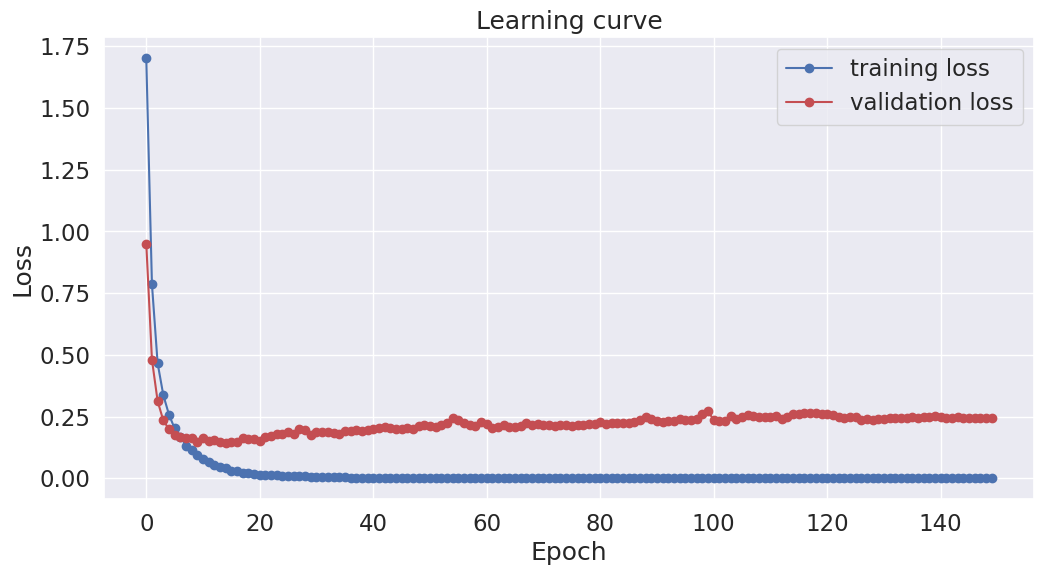

In [29]:
# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(loss_values, 'b-o', label="training loss")
plt.plot(validation_loss_values, 'r-o', label="validation loss")

# Label the plot.
plt.title("Learning curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.show()

# Performance on test data

In [30]:
print(test_acc)

[0.9504052996635437, 0.48050278425216675, 0.31275011599063873, 0.23458274453878403, 0.19901775072018305, 0.17474032938480377, 0.16697262972593307, 0.16398393486936888, 0.1631125621497631, 0.1469372051457564, 0.1647921105225881, 0.149257509658734, 0.15484370353321233, 0.14583206363022327, 0.14457068654398122, 0.14692724061508974, 0.14727559251089892, 0.16296200112750134, 0.15954635416467985, 0.15839056422313055, 0.1518144573395451, 0.1660615966344873, 0.17309301905333996, 0.17977271229028702, 0.18155800364911556, 0.18736749639113745, 0.17896203696727753, 0.2014767980823914, 0.1957267758746942, 0.17736895009875298, 0.18714513132969537, 0.18813041597604752, 0.18625865752498308, 0.18554417292277017, 0.17860949908693632, 0.19156750664114952, 0.19312463949124017, 0.19394177695115408, 0.193055534735322, 0.1942531323681275, 0.20103522017598152, 0.20289717242121696, 0.20884566443661848, 0.20343859369556108, 0.20127703746159872, 0.20182187979420027, 0.20380229875445366, 0.20082674796382585, 0.21

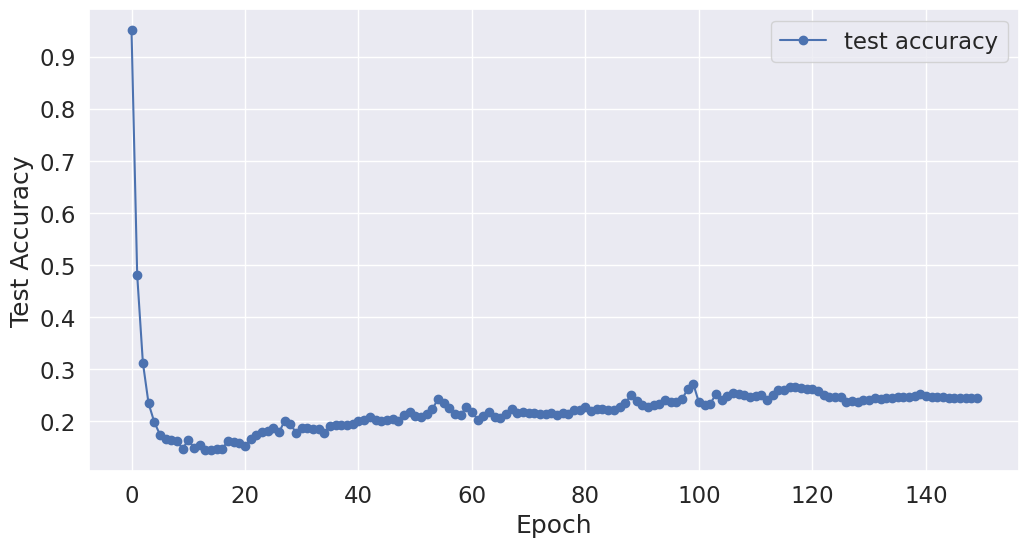

In [31]:
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(test_acc, 'b-o', label="test accuracy")


# Label the plot.
plt.title("")
plt.xlabel("Epoch")
plt.ylabel("Test Accuracy")
plt.legend()

plt.show()

In [32]:

print(acc(False, 6))
acc(True, 6)


6 1.0
0.6216451956907639
___________________0___________________

Predict labels:  ['0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'M', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Q', 'Q-cont', 'Q', 'Q-cont', '0', '0', '0', '0', '0', 'M', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Q', 'Q-cont', '0', '0', '0', '0', '0', '0', 'Q', '0', '0', '0', '0', '0', '0']
Actual labels:  ['0', '0', '0', 'R', 'R', 'R', 'R', 'R', '0', '0', '0', '0', '0', '0', '0', '0', 'M', '0', '0', '0', '0', '0', 'C', 'C', 'C-cont', 'C-cont', 'C-cont', 'C-cont', '0', 'C', 'C', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'R', 'R', 'R', 'R', 'R', '0', '0', '0',

___________________34___________________

Predict labels:  ['0', '0', '0', '0', 'PAD', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'T', 'T-cont', '0', 'PAD', 'PAD', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'T', 'T-cont', '0', '0', 'T', 'T-cont', '0', '0', '0', '0', '0']
Actual labels:  ['0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'M', 'M', '0', '0', '0', '0', '0', 'T', 'T-cont', '0', 'Q', 'Q', '0', '0', '0', '0', '0', '0', 'Q', 'Q', 'Q', 'Q', '0', '0', '0', '0', 'T', 'T-cont', '0', '0', '0', 'T', 'T-cont', '0', '0', '0', '0', '0', '0']


___________________35___________________

Predict labels:  ['0', '0', '0', '0', '0', 'Q', 'Q-cont', 'Q', '0', '0', 'Q', 'Q-cont', 'Q-cont', 'Q', 'Q-cont', 'Q-cont', '0', '0', '0', 'Q', 'Q', 'Q-cont', '0', '0', '0', '0', '0', '0', '0', '0', 'Q', 'Q-cont', 'Q', 'Q-cont', 'Q-cont', '0', 'M', '0', '0']
Actual labels:  ['0', 'M', 'M', '0', '0', '0', 'Q', 'Q-cont', 'Q-cont', 'Q-cont', '0', '0', 'Q', 'Q', 'Q', 'Q-cont', 'Q-cont', 'Q-cont', 'Q-cont'

___________________69___________________

Predict labels:  ['0', '0', '0', '0', 'Q', 'Q-cont', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'M', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Q', 'Q-cont', '0']
Actual labels:  ['0', '0', '0', '0', 'Q', 'Q-cont', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'M', 'M', '0', 'M', 'M', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Q', 'Q', 'Q-cont', 'Q-cont', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Q', 'Q-cont', 'Q-cont', 'Q-cont', 'Q-cont', '0', '0']


___________________70___________________

Predict labels:  ['0', '0', '0', '0', '0', 'M', '0', 'M', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Q', 'Q-cont', '0', '0', '0', '0', '0', '0', 'M', '

___________________104___________________

Predict labels:  ['0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Q', 'Q-cont', '0', '0', 'C', 'C-cont', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Q', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'T', 'T-cont', 'T-cont', 'T-cont', '0']
Actual labels:  ['0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Q', 'Q', 'Q', 'Q', 'Q', 'Q', '0', '0', '0', '0', '0', '0', '0', 'C', 'C', 'C', 'C', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Q', 'Q-cont', 'Q-cont', 'Q-cont', 'Q-cont', '0', '0', 'C', 'C', 'C', 'C-cont', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Q', 'Q', 'Q', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'T', 'T-cont', 'T-cont

___________________139___________________

Predict labels:  ['0', '0', '0', '0', 'C', '0', '0', 'C', '0', '0', '0', '0', '0', '0', '0', '0', 'M', '0', '0', 'M', '0', 'M', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'M', '0', 'M', '0', '0', '0', 'M', '0', 'M', '0', '0', '0', '0', '0', '0', 'C', '0', '0', 'C', 'C', '0', 'C', '0', '0', '0', '0', '0', 'M', '0', 'M', '0', '0', '0', '0']
Actual labels:  ['0', 'M', 'M', '0', '0', 'C', '0', '0', 'C', 'C', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'M', 'M', 'M', 'M', '0', 'M', 'M', 'M', 'M', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'M', 'M', 'M', 'M', '0', 'M', '0', '0', '0', 'M', 'M', 'M', 'M', 'M', 'M', 'M', '0', 'M', '0', '0', '0', '0', '0', '0', 'A', 'A', 'A', 'A', '0', '0', 'A', 'A', 'C', '0', 'C', '0', 'Q', 'Q', 'Q', 'Q', '0', '0', '0', 'M', 'M', 'M', 'M', 'M', 'M', 'M', '0', 'M', 'M', 'M', 'M', '0', '0', 'Q', 'Q', 'Q', '0']


___________________140__________________

0.6216451956907639

In [33]:
sentences, labels = processor(splitter2, labeler2)
print(acc(False, 146))
acc(True, 146)

160 1.0
0.8635530931361375
___________________0___________________

Predict labels:  ['0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'M', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Q', 'Q-cont', 'Q', 'Q-cont', '0', '0', '0', '0', 'M', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Q', '0', '0', '0', '0', '0', '0', 'Q', '0', '0', '0', '0', '0', '0']
Actual labels:  ['0', '0', '0', 'R', '0', '0', '0', '0', '0', '0', '0', '0', 'M', '0', '0', '0', '0', 'C', 'C-cont', 'C-cont', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'R', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'C', '0', '0', '0', '0', '0', '0', 'C', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Q', 'Q-cont', 'Q-cont', 'Q-cont

___________________34___________________

Predict labels:  ['0', '0', '0', '0', 'PAD', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'T', 'T-cont', '0', '0', '0', '0', '0', '0', '0', '0', 'T', 'T-cont', '0', 'T', 'T-cont', '0', '0', '0', '0', '0']
Actual labels:  ['0', '0', '0', '0', '0', '0', '0', '0', 'M', '0', '0', '0', '0', '0', 'T', 'T-cont', '0', '0', '0', '0', '0', '0', '0', '0', 'T', 'T-cont', '0', 'T', 'T-cont', '0', '0', '0', '0', '0']


___________________35___________________

Predict labels:  ['0', '0', '0', '0', '0', 'Q', 'Q-cont', 'Q', '0', '0', 'Q', 'Q-cont', 'Q-cont', 'Q', 'Q-cont', 'Q-cont', 'Q-cont', '0', 'Q', 'Q', 'Q-cont', '0', '0', '0', '0', '0', '0', '0', '0', 'Q', 'Q-cont', 'Q', 'Q-cont', 'Q-cont', 'Q-cont', 'PAD', '0']
Actual labels:  ['0', 'M', '0', '0', '0', 'Q', 'Q-cont', 'Q-cont', '0', '0', 'Q', 'Q-cont', 'Q-cont', 'Q-cont', 'Q-cont', 'Q-cont', '0', '0', '0', 'Q', 'Q-cont', '0', '0', 'C', 'C-cont', 'C-cont', '0', '0', '0', 'Q', 'Q-cont', 'Q-cont', 'Q-cont', 

___________________69___________________

Predict labels:  ['0', '0', '0', 'PAD', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Q', 'Q-cont', '0']
Actual labels:  ['0', '0', '0', '0', 'Q', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'M', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Q', 'Q-cont', '0', '0', '0', '0', '0', '0', '0', '0', 'Q', 'Q-cont', '0']


___________________70___________________

Predict labels:  ['0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'PAD', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'M', '0', 'M', '0', 'Q-cont', 'Q-cont', 'Q-cont', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Q', 'Q-cont', '0

___________________104___________________

Predict labels:  ['0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Q', 'Q-cont', '0', '0', 'C', 'C-cont', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Q', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'T', 'T-cont', 'T-cont', 'T-cont']
Actual labels:  ['0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Q', '0', '0', '0', '0', '0', '0', 'C', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Q', 'Q-cont', '0', '0', 'C', 'C-cont', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Q', 'Q-cont', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'T', 'T-cont', 'T-cont', 'T-cont']


___________________105___________________

Predict labels:  ['0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0',

___________________139___________________

Predict labels:  ['0', '0', '0', '0', 'C', '0', '0', 'C', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'C', 'C', '0', 'C', '0', '0', '0', '0', '0', '0', '0', '0']
Actual labels:  ['0', 'M', '0', '0', 'C', '0', '0', 'C', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'M', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'M', '0', '0', '0', '0', '0', '0', '0', '0', 'A', '0', '0', 'A', '0', '0', 'C', '0', 'Q', '0', '0', 'M', '0', '0', 'Q']


___________________140___________________

Predict labels:  ['0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0',

0.8635530931361375

In [34]:
sentences, labels = [], []
for i in range(len(info)):
    sent, label = all_in_one(info[i]['text'], info[i]['annotations'])
    sentences.append(sent)
    labels.append(label)
print(acc(False, 147))
acc(True, 147)

147 1.0
0.8711048782894573
___________________0___________________

Predict labels:  ['0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'M', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Q', 'Q-cont', 'Q', 'Q-cont', '0', '0', '0', '0', '0', 'M', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Q', 'Q-cont', 'PAD', '0', '0', '0', '0', '0', '0']
Actual labels:  ['0', '0', '0', 'R', '0', '0', '0', '0', '0', '0', '0', '0', 'M', '0', '0', '0', '0', 'C', 'C-cont', 'C-cont', '0', 'C', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'R', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'C', '0', '0', '0', '0', '0', '0', 'C', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Q', 'Q-cont', 

___________________34___________________

Predict labels:  ['0', '0', '0', '0', 'PAD', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'T', 'T-cont', '0', 'PAD', 'PAD', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'T', 'T-cont', 'T', 'T-cont', '0', '0', '0', '0', '0']
Actual labels:  ['0', '0', '0', '0', '0', '0', '0', '0', 'M', '0', '0', '0', '0', '0', 'T', 'T-cont', '0', 'Q', '0', '0', '0', '0', '0', 'Q', '0', '0', '0', '0', 'T', 'T-cont', 'T', 'T-cont', '0', '0', '0', '0', '0']


___________________35___________________

Predict labels:  ['0', '0', '0', '0', '0', 'Q', 'Q-cont', 'Q', '0', '0', 'Q', 'Q-cont', 'Q-cont', 'Q', 'Q-cont', 'Q-cont', '0', '0', '0', '0', 'Q', 'Q-cont', '0', '0', '0', '0', '0', '0', '0', '0', 'Q', 'Q-cont', 'Q', 'Q-cont', 'Q-cont', 'Q-cont', '0', '0']
Actual labels:  ['0', 'M', '0', '0', '0', 'Q', 'Q-cont', 'Q-cont', '0', '0', 'Q', 'Q-cont', 'Q-cont', 'Q-cont', 'Q-cont', 'Q-cont', '0', '0', '0', '0', 'Q', 'Q-cont', '0', '0', 'C', 'C-cont', 'C-cont', '0', '0', '0'

___________________69___________________

Predict labels:  ['0', '0', '0', '0', 'Q', 'Q-cont', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Q', 'Q-cont', 'Q-cont', 'Q-cont', 'PAD']
Actual labels:  ['0', '0', '0', '0', 'Q', 'Q-cont', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'M', '0', 'M', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Q', 'Q-cont', 'Q', 'Q-cont', '0']


___________________70___________________

Predict labels:  ['0', '0', '0', '0', '0', 'M', '0', 'M', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Q', 'Q-cont', '0', '0', '0', '0', '0', '0', 'M', '0', 'M', 'M', '0', '0', '0', '0', 'M', '0', 'M', '0', 'Q', 'Q-cont', 'Q-cont', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Q', 'Q-cont', '0',

___________________104___________________

Predict labels:  ['0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Q', 'Q-cont', '0', '0', 'C', 'C-cont', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'T', 'T-cont', 'T-cont', 'T-cont', '0']
Actual labels:  ['0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Q', '0', '0', '0', '0', '0', '0', 'C', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Q', 'Q-cont', '0', '0', 'C', 'C-cont', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Q', 'T', 'T-cont', 'T-cont', 'T-cont', '0']


___________________105___________________

Predict labels:  ['0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'PAD', '0', '0', '0', '0', '0', 'PAD', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'T', 'T-cont', '0', '0', '0', '0', '0', '0', '0', '0', '0', 

___________________139___________________

Predict labels:  ['0', '0', '0', '0', 'C', '0', '0', 'C', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'M', '0', 'M', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'M', '0', 'M', '0', '0', '0', 'M', '0', 'M', '0', '0', '0', '0', '0', '0', 'C', '0', '0', 'C', 'C', '0', 'C', '0', '0', '0', '0', '0', 'M', '0', '0', '0', '0']
Actual labels:  ['0', 'M', '0', '0', 'C', '0', '0', 'C', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'M', '0', 'M', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'M', '0', 'M', '0', '0', '0', 'M', '0', 'M', '0', '0', '0', '0', '0', '0', 'A', '0', '0', 'A', 'C', '0', 'C', '0', 'Q', '0', '0', '0', 'M', '0', 'M', 'Q', '0']


___________________140___________________

Predict labels:  ['0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'M', '0', 'M', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'M', '0', 'M', '0', 'M', '0', 'M', '0', '0', '0',

0.8711048782894573

In [35]:
model = torch.load("test.ck")
model.eval()


sentences, labels = processor(splitter1, labeler1)
print(acc(False, 103))
print(acc(True, 103))

103 0.9361702127659575
0.5939491910416042
___________________0___________________

Predict labels:  ['0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Q', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0']
Actual labels:  ['0', '0', '0', 'R', 'R-cont', '0', '0', '0', '0', '0', '0', '0', '0', 'M', '0', '0', '0', '0', 'C', 'C-cont', 'C-cont', 'C-cont', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'R', 'R-cont', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'C', '0', '0', '0', '0', '0', '0', 'C', '0', '0

___________________34___________________

Predict labels:  ['0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0']
Actual labels:  ['0', '0', '0', '0', '0', '0', '0', '0', 'M', '0', '0', '0', '0', '0', 'T', 'T-cont', 'Q', '0', '0', '0', 'Q', 'Q-cont', '0', '0', '0', 'T', 'T-cont', '0', 'T', 'T-cont', '0']


___________________35___________________

Predict labels:  ['0', 'C', 'Q', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'C-cont', '0', '0', 'C-cont', '0', '0', '0', '0', '0', '0']
Actual labels:  ['0', 'M', '0', '0', '0', 'Q', 'Q-cont', 'Q-cont', '0', '0', 'Q', 'Q-cont', 'Q-cont', 'Q-cont', 'Q-cont', 'Q-cont', 'Q-cont', 'Q-cont', 'Q-cont', '0', '0', '0', 'Q', 'Q-cont', '0', '0', 'C', 'C-cont', 'C-cont', '0', '0', '0', 'Q', 'Q-cont', 'Q-cont', 'Q-cont', 'Q-cont', 'Q-cont',

___________________69___________________

Predict labels:  ['0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'C', '0']
Actual labels:  ['0', '0', '0', 'Q', 'Q-cont', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'M', 'M-cont', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Q', 'Q-cont', '0', '0', '0', '0', '0', '0', '0', '0', 'Q', 'Q-cont', 'Q-cont']


___________________70___________________

Predict labels:  ['0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'C', 'C', 'C', 'C-cont', 'C-cont', '0', '0', '0', '0', '0', '0', 'C', 'C', 'C-cont', 'C-cont', '0', '0', '0', '0', '0', 'C', 'C', 'C-cont', 'C-cont', '0', '0', '0', '

___________________104___________________

Predict labels:  ['0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'C', 'M-cont', 'M-cont', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'C', 'M-cont', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'C', '0', '0', '0', '0', '0', '0', 'C-cont', '0', 'C', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0']
Actual labels:  ['0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Q', 'Q-cont', '0', '0', '0', '0', '0', '0', 'C', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Q', 'Q-cont', '0', '0', 'C', 'C-cont', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Q', 'Q-cont', 'Q-cont', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'T', 'T-cont', 'T-cont', 'T-cont']


___________________105___________________

Predict labels:  ['0', '0', '0', '0', '0', '0', '0', '0',

___________________139___________________

Predict labels:  ['0', '0', 'Q', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'C', 'C-cont', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'M', 'M', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0']
Actual labels:  ['0', 'M', '0', '0', 'C', '0', '0', 'C', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'M', 'M-cont', 'M-cont', 'M-cont', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'M', 'M-cont', 'M-cont', '0', '0', 'M', 'M-cont', 'M-cont', '0', '0', '0', '0', '0', 'A', '0', '0', 'A', 'C', '0', 'C', '0', 'Q', 'Q-cont', '0', '0', 'M', 'M-cont', 'M-cont', 'M-cont', '0', '0', 'Q', 'Q-cont']


___________________140___________________

Predict labels:  ['0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0',

In [36]:
sentences, labels = processor(splitter2, labeler2)
print(acc(False, 24))
acc(True, 24)

24 0.9666666666666667
0.7567635984056995
___________________0___________________

Predict labels:  ['0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0']
Actual labels:  ['0', '0', '0', 'R', '0', '0', '0', '0', '0', '0', '0', '0', 'M', '0', '0', '0', '0', 'C', 'C-cont', 'C-cont', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'R', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'C', '0', '0', '0', '0', '0', '0', 'C', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Q', 'Q-cont', 'Q-cont', 'Q-

___________________34___________________

Predict labels:  ['0', '0', '0', '0', '0', '0', '0', '0', '0', 'C-cont', '0', '0', 'C-cont', '0', 'C-cont', '0', 'C-cont', 'C-cont', '0', '0', 'C-cont', 'C-cont', 'C-cont', 'C-cont', 'C-cont', 'C', 'C', 'C-cont', 'C-cont', 'C-cont', '0', '0', '0', '0']
Actual labels:  ['0', '0', '0', '0', '0', '0', '0', '0', 'M', '0', '0', '0', '0', '0', 'T', 'T-cont', '0', '0', '0', '0', '0', '0', '0', '0', 'T', 'T-cont', '0', 'T', 'T-cont', '0', '0', '0', '0', '0']


___________________35___________________

Predict labels:  ['0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'C-cont', '0', '0', '0', '0', '0']
Actual labels:  ['0', 'M', '0', '0', '0', 'Q', 'Q-cont', 'Q-cont', '0', '0', 'Q', 'Q-cont', 'Q-cont', 'Q-cont', 'Q-cont', 'Q-cont', '0', '0', '0', 'Q', 'Q-cont', '0', '0', 'C', 'C-cont', 'C-cont', '0', '0', '0', 'Q', 'Q-cont', 'Q-cont', 'Q-cont', 'Q-c

___________________69___________________

Predict labels:  ['0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0']
Actual labels:  ['0', '0', '0', '0', 'Q', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'M', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Q', 'Q-cont', '0', '0', '0', '0', '0', '0', '0', '0', 'Q', 'Q-cont', '0']


___________________70___________________

Predict labels:  ['0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'C', '0', '0', '0', '0', '0', '0', 'C', 'C', 'C', 'C-cont', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'C', 'C-cont', '0', '0', '0', '0', '0', 'C', 'C', 'C-cont', 'C-cont', '0', '0', '0', '0', '0', '0', '0', 'C', '

___________________104___________________

Predict labels:  ['0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'C-cont', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'C-cont', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0']
Actual labels:  ['0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Q', '0', '0', '0', '0', '0', '0', 'C', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Q', 'Q-cont', '0', '0', 'C', 'C-cont', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Q', 'Q-cont', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'T', 'T-cont', 'T-cont', 'T-cont']


___________________105___________________

Predict labels:  ['0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0',

___________________139___________________

Predict labels:  ['0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Q', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'PAD']
Actual labels:  ['0', 'M', '0', '0', 'C', '0', '0', 'C', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'M', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'M', '0', '0', '0', '0', '0', '0', '0', '0', 'A', '0', '0', 'A', '0', '0', 'C', '0', 'Q', '0', '0', 'M', '0', '0', 'Q']


___________________140___________________

Predict labels:  ['0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0

0.7567635984056995

In [37]:
sentences, labels = [], []
for i in range(len(info)):
    sent, label = all_in_one(info[i]['text'], info[i]['annotations'])
    sentences.append(sent)
    labels.append(label)
print(acc(False, 94))
acc(True, 94)

94 0.953125
0.7323276967190304
___________________0___________________

Predict labels:  ['0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'PAD']
Actual labels:  ['0', '0', '0', 'R', '0', '0', '0', '0', '0', '0', '0', '0', 'M', '0', '0', '0', '0', 'C', 'C-cont', 'C-cont', '0', 'C', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'R', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'C', '0', '0', '0', '0', '0', '0', 'C', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Q', 'Q-cont', 'Q-cont', '

___________________34___________________

Predict labels:  ['0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0']
Actual labels:  ['0', '0', '0', '0', '0', '0', '0', '0', 'M', '0', '0', '0', '0', '0', 'T', 'T-cont', '0', 'Q', '0', '0', '0', '0', '0', 'Q', '0', '0', '0', '0', 'T', 'T-cont', 'T', 'T-cont', '0', '0', '0', '0', '0']


___________________35___________________

Predict labels:  ['0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'PAD', '0', '0', '0', '0', '0', '0', '0', '0', 'C-cont', '0', '0', '0', '0', '0']
Actual labels:  ['0', 'M', '0', '0', '0', 'Q', 'Q-cont', 'Q-cont', '0', '0', 'Q', 'Q-cont', 'Q-cont', 'Q-cont', 'Q-cont', 'Q-cont', '0', '0', '0', '0', 'Q', 'Q-cont', '0', '0', 'C', 'C-cont', 'C-cont', '0', '0', '0', 'Q', 'Q-cont', 'Q-cont', 'Q-cont', 'Q-cont', 'M', '0', '0']




___________________69___________________

Predict labels:  ['0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0']
Actual labels:  ['0', '0', '0', '0', 'Q', 'Q-cont', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'M', '0', 'M', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Q', 'Q-cont', 'Q', 'Q-cont', '0']


___________________70___________________

Predict labels:  ['0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'C', 'C', 'C', 'C-cont', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'A', 'M', '0', '0', '0', '0', '0', 'C', 'C', 'C-cont', 'C-cont', '0', '0', '0', '0', '0', '0', '0', '0', 'C', 'A', 'M', '0', '

___________________104___________________

Predict labels:  ['0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'C-cont', '0', '0', '0', '0', '0', '0', 'C-cont', '0', '0', '0', '0', '0', '0', 'C', '0', '0', '0', '0', '0', '0', '0', '0']
Actual labels:  ['0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Q', '0', '0', '0', '0', '0', '0', 'C', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Q', 'Q-cont', '0', '0', 'C', 'C-cont', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Q', 'T', 'T-cont', 'T-cont', 'T-cont', '0']


___________________105___________________

Predict labels:  ['0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0',

___________________139___________________

Predict labels:  ['0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'PAD', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'C', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0']
Actual labels:  ['0', 'M', '0', '0', 'C', '0', '0', 'C', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'M', '0', 'M', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'M', '0', 'M', '0', '0', '0', 'M', '0', 'M', '0', '0', '0', '0', '0', '0', 'A', '0', '0', 'A', 'C', '0', 'C', '0', 'Q', '0', '0', '0', 'M', '0', 'M', 'Q', '0']


___________________140___________________

Predict labels:  ['0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0

0.7323276967190304

In [38]:
print(max_test)

0.14457068654398122
